In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [2]:
# define 14 tickers to use
tickers_list = ['AAPL', 'MSFT', 'WMT', 'IBM', 'MU', 'BA', 'AXP',  'NVDA', 'FB', 'OXY', 'TSLA', 'JNJ', 'NFLX', 'DIS']
from_date, to_date = '2014-03-01','2019-03-12'

In [3]:
def get_close_prices(tick_list, from_date, to_date):
    return yf.download(tickers_list, from_date, to_date )['Adj Close']
    
data_set_df = get_close_prices(tickers_list, from_date, to_date )
data_set_df.head()

[*********************100%***********************]  14 of 14 completed


,AAPL,AXP,BA,DIS,FB,IBM,JNJ,MSFT,MU,NFLX,NVDA,OXY,TSLA,WMT
Date,,,,,,,,,,,,,,
2014-02-28,67.710892,82.985603,109.956337,74.370750,68.459999,143.043030,77.661484,33.542198,24.190001,63.661430,17.468288,68.559456,244.809998,63.410374
2014-03-03,67.906464,81.794632,109.359322,73.128334,67.410004,142.340057,77.189392,33.078148,24.480000,63.655716,17.382755,68.225609,250.559998,62.918026
2014-03-04,68.354248,84.194740,111.073647,75.199028,68.800003,144.024139,78.690002,33.629753,25.110001,64.997147,17.563324,69.056671,254.839996,63.775372
2014-03-05,68.498352,83.767448,109.845436,76.091743,71.570000,144.564880,78.057709,33.367085,24.830000,64.785713,17.715389,68.793854,252.660004,63.495262
2014-03-06,68.291168,85.022049,109.905167,76.699165,70.839996,144.951080,78.310631,33.402107,24.770000,64.358574,17.468288,68.894035,252.940002,63.563164


## Label Data

In [9]:
dataset_df = pd.concat([data_set_df, pd.DataFrame( columns = [x + '_Signal' for x in tickers_list] )]).reset_index()

window = 11
for ticker in tickers_list:
    for idx in range(dataset_df.shape[0]):
        if int(idx)>window:
            #print(type(idx))
            start_idx = idx - window
            end_idx = idx
            prices = dataset_df[ticker].iloc[start_idx:end_idx]
            max_idx = max(enumerate(prices.tolist()),key=lambda x: x[1])[0]
            min_idx =  min(enumerate(prices.tolist()),key=lambda x: x[1])[0]        
            pos = int(end_idx-6)
            if max_idx == window//2:
                dataset_df.at[pos, [f'{ticker}_Signal']]  = 'Sell'         
            elif min_idx == window//2:
                dataset_df.at[pos, [f'{ticker}_Signal']]  = 'Buy'        
            else:
                dataset_df.at[pos, [f'{ticker}_Signal']] = 'Hold'

dataset_df = dataset_df.reindex(sorted(dataset_df.columns), axis=1)

In [10]:
dataset_df = dataset_df.set_index('index')

In [11]:
training_df = dataset_df[11:-6]##.to_csv('C:\\Users\\andre\\Desktop\\test.csv')

In [12]:
training_df.shape[0]

1249

## Create the Training Set

The values of the technical indicators are the same as the Technical analysis strategy

In [13]:
def EMA_features(df, col, short_win =35, long_win = 70 ):
        return df[col].ewm(span = long_win).mean(), df[col].ewm(span = short_win).mean()

def RSI_feature(df, col, rsi_win = 14):
    diff = df[col].diff(1).dropna()
    up_c = 0 * diff
    down_c = 0 * diff
    up_c[diff > 0]  = diff[ diff>0 ]
    down_c[diff < 0] =  diff[ diff < 0 ]
    up_c_avg   = up_c.ewm(com=rsi_win-1 , min_periods=rsi_win).mean()
    down_c_avg = down_c.ewm(com=rsi_win-1 , min_periods=rsi_win).mean()
    rs = abs(up_c_avg/down_c_avg)
    rsi = 100 - 100/(1+rs)
    return rsi
    

The training set includes the 3 technical indicators as well as the previous 10 days prices

In [14]:
list_of_dfs = []
dict_of_datasets = {}
for ticker in tickers_list:
    # 
    df = training_df[[ticker, ticker + '_Signal']]
    df['t-10'] = df[ticker].shift(10)
    df['t-9'] = df[ticker].shift(9)
    df['t-8'] = df[ticker].shift(8)
    df['t-7'] = df[ticker].shift(7)
    df['t-6'] = df[ticker].shift(6)
    df['t-5'] = df[ticker].shift(5)
    df['t-4'] = df[ticker].shift(4)
    df['t-3'] = df[ticker].shift(3)
    df['t-2'] = df[ticker].shift(2)
    df['t-1'] = df[ticker].shift(1)
    
    df[ticker + '_NormPrice'] = df[[ticker]].apply( lambda x: x/x.max() )
    
    df[df.columns.difference([ticker, ticker + '_Signal'])] = df[df.columns.difference([ticker, ticker + '_Signal'])].apply(lambda x: (x/x.max()))

    df[ticker + '_RSI'] = RSI_feature(df, ticker)
    df[ticker + '_slow'], df[ticker + '_fast'] = EMA_features(df, ticker + '_NormPrice' )

    df = df[19:]
    df[ticker + '_Signal'] = np.where(df[ticker + '_Signal']=='Buy', 2, np.where(df[ticker + '_Signal']=='Hold', 1, 0))
    X = pd.DataFrame(df.values, columns=df.columns)
    y = df[ticker + '_Signal']

    smote = SMOTE(random_state=45)
    X_resampled, y_resampled = smote.fit_sample(X, y)

    df = pd.DataFrame(X_resampled, columns=X.columns)
    train, test = train_test_split(df, test_size=0.25)
    train, val = train_test_split(train, test_size=0.2)

    
    dict_of_datasets[ticker] = [train, val, test ]
    
    list_of_dfs.append(df)

C:\Users\andre\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\andre\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\andre\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

C:\Users\andre\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\andre\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\andre\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

C:\Users\andre\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\andre\Anaconda3\envs\tf_gpu\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\andre\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

C:\Users\andre\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\andre\Anaconda3\envs\tf_gpu\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\andre\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

C:\Users\andre\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\andre\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\andre\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

C:\Users\andre\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\andre\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\andre\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

C:\Users\andre\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\andre\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\andre\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

C:\Users\andre\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\andre\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\andre\Anaconda3\envs\tf_gpu\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

### Create Dataset compatible with Tensorflow

In [15]:
tf.keras.backend.set_floatx('float32')

def df_to_dataset(dataframe, ticker, shuffle=True, batch_size=32):
    
  dataframe = dataframe.copy()
  labels = dataframe.pop(ticker + '_Signal')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds


### Train Model

We train one model per ticker, which is saved in a dictionary in order to be used in the next steps

In [17]:
tf.keras.backend.set_floatx('float32')
dict_of_models = {}


for ticker in tickers_list:
    feature_columns = [feature_column.numeric_column(x) for x in ['t-10','t-9', 't-8',\
                                                                  't-7','t-6','t-5', 't-4', 't-3', 't-2','t-1',\
                                                                ticker + '_RSI', ticker +'_slow',\
                                                                  ticker +'_fast', ticker + '_NormPrice']]
    
    feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
    
    train_ds = df_to_dataset(dict_of_datasets[ticker][0], ticker)
    val_ds = df_to_dataset(dict_of_datasets[ticker][1], ticker)
    test_ds = df_to_dataset(dict_of_datasets[ticker][2], ticker)

    model = tf.keras.Sequential([
      feature_layer,
      layers.Dense(64, activation='relu'), 
      layers.Dense(128, activation='relu'),
      
      layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dropout(.1),
      layers.Dense(32, activation='relu'),
        
      layers.Dense(3)
    ])

    model.compile(optimizer='adam',
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics= ['categorical_crossentropy']
)
    
    
    model.fit(train_ds,
              validation_data=val_ds,
              epochs=100, shuffle=True)
    loss, accuracy = model.evaluate(test_ds)

    
    dict_of_models[ticker] = model


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/100
62/62 [==============================] - 5s 81ms/step - loss: 1.1644 - categorical_crossentropy: 5.1054 - val_loss: 0.0000e+00 - val_categorical_crossentropy: 0.0000e+00
Epoch 2/100
62/62 [==============================] - 1s 20ms/step - loss: 1.0795 - categorical_crossentropy: 17.8504 - val_loss: 1.0621 - val_categorical_crossentropy: 19.5562
Epoch 3/100
62/62 [==============================] - 1s 20ms/step - loss: 1.0391 - categorical_crossentropy: 17.3212 - val_loss: 1.0012 - val_categori

62/62 [==============================] - 1s 20ms/step - loss: 0.8445 - categorical_crossentropy: 19.7766 - val_loss: 0.8086 - val_categorical_crossentropy: 20.5498
Epoch 90/100
62/62 [==============================] - 1s 20ms/step - loss: 0.8580 - categorical_crossentropy: 20.5719 - val_loss: 0.8205 - val_categorical_crossentropy: 19.1662
Epoch 91/100
62/62 [==============================] - 1s 20ms/step - loss: 0.8506 - categorical_crossentropy: 19.3301 - val_loss: 0.8097 - val_categorical_crossentropy: 18.1149
Epoch 92/100
62/62 [==============================] - 1s 23ms/step - loss: 0.8464 - categorical_crossentropy: 19.7833 - val_loss: 0.7993 - val_categorical_crossentropy: 19.4854
Epoch 93/100
62/62 [==============================] - 1s 22ms/step - loss: 0.8400 - categorical_crossentropy: 19.8797 - val_loss: 0.8152 - val_categorical_crossentropy: 18.6835
Epoch 94/100
62/62 [==============================] - 1s 21ms/step - loss: 0.8435 - categorical_crossentropy: 20.4370 - val_loss

Epoch 35/100
60/60 [==============================] - 1s 19ms/step - loss: 0.8490 - categorical_crossentropy: 30.5222 - val_loss: 0.8164 - val_categorical_crossentropy: 29.2449
Epoch 36/100
60/60 [==============================] - 1s 20ms/step - loss: 0.8527 - categorical_crossentropy: 30.4940 - val_loss: 0.8496 - val_categorical_crossentropy: 28.1404
Epoch 37/100
60/60 [==============================] - 1s 20ms/step - loss: 0.8632 - categorical_crossentropy: 29.7814 - val_loss: 0.8725 - val_categorical_crossentropy: 29.2235
Epoch 38/100
60/60 [==============================] - 1s 20ms/step - loss: 0.8761 - categorical_crossentropy: 29.5971 - val_loss: 0.8576 - val_categorical_crossentropy: 28.4350
Epoch 39/100
60/60 [==============================] - 1s 21ms/step - loss: 0.8539 - categorical_crossentropy: 29.4584 - val_loss: 0.8505 - val_categorical_crossentropy: 26.5604
Epoch 40/100
60/60 [==============================] - 1s 21ms/step - loss: 0.8543 - categorical_crossentropy: 30.02

Epoch 23/100
61/61 [==============================] - 1s 20ms/step - loss: 0.8892 - categorical_crossentropy: 16.3418 - val_loss: 0.9125 - val_categorical_crossentropy: 17.2295
Epoch 24/100
61/61 [==============================] - 1s 20ms/step - loss: 0.9059 - categorical_crossentropy: 16.8502 - val_loss: 0.9321 - val_categorical_crossentropy: 18.8770
Epoch 25/100
61/61 [==============================] - 1s 20ms/step - loss: 0.8820 - categorical_crossentropy: 16.0718 - val_loss: 0.9149 - val_categorical_crossentropy: 18.4470
Epoch 26/100
61/61 [==============================] - 1s 20ms/step - loss: 0.8782 - categorical_crossentropy: 16.3965 - val_loss: 0.8926 - val_categorical_crossentropy: 18.1133
Epoch 27/100
61/61 [==============================] - 1s 22ms/step - loss: 0.8843 - categorical_crossentropy: 17.8322 - val_loss: 0.8811 - val_categorical_crossentropy: 17.4627
Epoch 28/100
61/61 [==============================] - 1s 21ms/step - loss: 0.8835 - categorical_crossentropy: 17.54

Epoch 11/100
61/61 [==============================] - 1s 21ms/step - loss: 0.9057 - categorical_crossentropy: 20.2224 - val_loss: 0.9241 - val_categorical_crossentropy: 15.9437
Epoch 12/100
61/61 [==============================] - 1s 20ms/step - loss: 0.8947 - categorical_crossentropy: 17.5687 - val_loss: 0.9279 - val_categorical_crossentropy: 17.8984
Epoch 13/100
61/61 [==============================] - 1s 20ms/step - loss: 0.9015 - categorical_crossentropy: 17.9885 - val_loss: 0.9381 - val_categorical_crossentropy: 18.2620
Epoch 14/100
61/61 [==============================] - 1s 20ms/step - loss: 0.9006 - categorical_crossentropy: 17.5937 - val_loss: 0.9223 - val_categorical_crossentropy: 17.0268
Epoch 15/100
61/61 [==============================] - 1s 19ms/step - loss: 0.9003 - categorical_crossentropy: 17.3114 - val_loss: 0.9401 - val_categorical_crossentropy: 15.4334
Epoch 16/100
61/61 [==============================] - 1s 23ms/step - loss: 0.9042 - categorical_crossentropy: 16.36

Epoch 3/100
61/61 [==============================] - 1s 19ms/step - loss: 1.0688 - categorical_crossentropy: 14.2792 - val_loss: 1.0453 - val_categorical_crossentropy: 3.6845
Epoch 4/100
61/61 [==============================] - 1s 19ms/step - loss: 1.0489 - categorical_crossentropy: 10.0401 - val_loss: 1.0289 - val_categorical_crossentropy: 15.9801
Epoch 5/100
61/61 [==============================] - 1s 21ms/step - loss: 1.0387 - categorical_crossentropy: 16.3745 - val_loss: 1.0046 - val_categorical_crossentropy: 17.2563
Epoch 6/100
61/61 [==============================] - 1s 22ms/step - loss: 1.0170 - categorical_crossentropy: 15.7757 - val_loss: 0.9668 - val_categorical_crossentropy: 13.7223
Epoch 7/100
61/61 [==============================] - 1s 21ms/step - loss: 1.0202 - categorical_crossentropy: 15.5809 - val_loss: 0.9755 - val_categorical_crossentropy: 17.4828
Epoch 8/100
61/61 [==============================] - 1s 19ms/step - loss: 0.9911 - categorical_crossentropy: 16.7728 - va

61/61 [==============================] - 1s 21ms/step - loss: 0.7448 - categorical_crossentropy: 27.3856 - val_loss: 0.7173 - val_categorical_crossentropy: 27.8241
Epoch 96/100
61/61 [==============================] - 1s 21ms/step - loss: 0.7123 - categorical_crossentropy: 27.5668 - val_loss: 0.7236 - val_categorical_crossentropy: 27.3249
Epoch 97/100
61/61 [==============================] - 1s 20ms/step - loss: 0.7588 - categorical_crossentropy: 26.9861 - val_loss: 0.8522 - val_categorical_crossentropy: 29.5065
Epoch 98/100
61/61 [==============================] - 1s 20ms/step - loss: 0.7461 - categorical_crossentropy: 27.1037 - val_loss: 0.7242 - val_categorical_crossentropy: 28.7509
Epoch 99/100
61/61 [==============================] - 1s 20ms/step - loss: 0.7378 - categorical_crossentropy: 27.4671 - val_loss: 1.2293 - val_categorical_crossentropy: 29.8888
Epoch 100/100
26/26 [==============================] - 1s 50ms/step - loss: 0.7453 - categorical_crossentropy: 30.0480
Epoch 1/1

Epoch 41/100
61/61 [==============================] - 1s 20ms/step - loss: 0.8765 - categorical_crossentropy: 25.7761 - val_loss: 0.8575 - val_categorical_crossentropy: 24.4340
Epoch 42/100
61/61 [==============================] - 1s 20ms/step - loss: 0.8700 - categorical_crossentropy: 24.9542 - val_loss: 0.9119 - val_categorical_crossentropy: 23.0678
Epoch 43/100
61/61 [==============================] - 1s 19ms/step - loss: 0.8751 - categorical_crossentropy: 24.1656 - val_loss: 0.9188 - val_categorical_crossentropy: 22.7026
Epoch 44/100
61/61 [==============================] - 1s 20ms/step - loss: 0.8730 - categorical_crossentropy: 25.9751 - val_loss: 0.8651 - val_categorical_crossentropy: 24.1343
Epoch 45/100
61/61 [==============================] - 1s 19ms/step - loss: 0.8600 - categorical_crossentropy: 25.5619 - val_loss: 0.8694 - val_categorical_crossentropy: 25.9716
Epoch 46/100
61/61 [==============================] - 1s 21ms/step - loss: 0.8633 - categorical_crossentropy: 26.73

Epoch 29/100
61/61 [==============================] - 1s 21ms/step - loss: 0.8826 - categorical_crossentropy: 19.1311 - val_loss: 0.8633 - val_categorical_crossentropy: 16.7139
Epoch 30/100
61/61 [==============================] - 1s 21ms/step - loss: 0.9090 - categorical_crossentropy: 19.8875 - val_loss: 0.7926 - val_categorical_crossentropy: 18.0909
Epoch 31/100
61/61 [==============================] - 1s 22ms/step - loss: 0.8903 - categorical_crossentropy: 19.5387 - val_loss: 0.8032 - val_categorical_crossentropy: 18.4645
Epoch 32/100
61/61 [==============================] - 2s 26ms/step - loss: 0.8851 - categorical_crossentropy: 19.4242 - val_loss: 0.8495 - val_categorical_crossentropy: 18.4172
Epoch 33/100
61/61 [==============================] - 1s 22ms/step - loss: 0.8914 - categorical_crossentropy: 19.7542 - val_loss: 0.8010 - val_categorical_crossentropy: 18.5349
Epoch 34/100
61/61 [==============================] - 1s 20ms/step - loss: 0.8838 - categorical_crossentropy: 17.97

Epoch 17/100
62/62 [==============================] - 1s 20ms/step - loss: 0.9389 - categorical_crossentropy: 15.4511 - val_loss: 1.2512 - val_categorical_crossentropy: 15.1271
Epoch 18/100
62/62 [==============================] - 1s 20ms/step - loss: 0.9500 - categorical_crossentropy: 14.6044 - val_loss: 1.0411 - val_categorical_crossentropy: 15.5950
Epoch 19/100
62/62 [==============================] - 1s 20ms/step - loss: 0.9468 - categorical_crossentropy: 17.0779 - val_loss: 0.9101 - val_categorical_crossentropy: 14.8276
Epoch 20/100
62/62 [==============================] - 1s 20ms/step - loss: 0.9203 - categorical_crossentropy: 16.1343 - val_loss: 0.9496 - val_categorical_crossentropy: 15.7977
Epoch 21/100
62/62 [==============================] - 1s 20ms/step - loss: 0.9061 - categorical_crossentropy: 16.0116 - val_loss: 0.9427 - val_categorical_crossentropy: 14.7859
Epoch 22/100
62/62 [==============================] - 1s 20ms/step - loss: 0.9178 - categorical_crossentropy: 16.07

Epoch 5/100
61/61 [==============================] - 1s 21ms/step - loss: 1.0112 - categorical_crossentropy: 5.6116 - val_loss: 1.0176 - val_categorical_crossentropy: 5.9684
Epoch 6/100
61/61 [==============================] - 1s 21ms/step - loss: 0.9855 - categorical_crossentropy: 5.9581 - val_loss: 0.9700 - val_categorical_crossentropy: 7.5568
Epoch 7/100
61/61 [==============================] - 1s 21ms/step - loss: 0.9806 - categorical_crossentropy: 7.1462 - val_loss: 0.9608 - val_categorical_crossentropy: 10.5036
Epoch 8/100
61/61 [==============================] - 1s 20ms/step - loss: 0.9565 - categorical_crossentropy: 7.3611 - val_loss: 0.9529 - val_categorical_crossentropy: 8.8784
Epoch 9/100
61/61 [==============================] - 1s 21ms/step - loss: 0.9546 - categorical_crossentropy: 7.4002 - val_loss: 0.9922 - val_categorical_crossentropy: 7.0695
Epoch 10/100
61/61 [==============================] - 1s 20ms/step - loss: 0.9446 - categorical_crossentropy: 7.6971 - val_loss: 

61/61 [==============================] - 1s 20ms/step - loss: 0.7705 - categorical_crossentropy: 15.4251 - val_loss: 0.7972 - val_categorical_crossentropy: 20.0298
Epoch 98/100
61/61 [==============================] - 1s 20ms/step - loss: 0.7761 - categorical_crossentropy: 14.6291 - val_loss: 0.8074 - val_categorical_crossentropy: 17.1351
Epoch 99/100
61/61 [==============================] - 1s 20ms/step - loss: 0.7701 - categorical_crossentropy: 15.3994 - val_loss: 0.7896 - val_categorical_crossentropy: 17.1445
Epoch 100/100
26/26 [==============================] - 0s 12ms/step - loss: 0.7881 - categorical_crossentropy: 17.4312

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constru

Epoch 39/100
61/61 [==============================] - 1s 21ms/step - loss: 0.8901 - categorical_crossentropy: 21.2460 - val_loss: 0.9086 - val_categorical_crossentropy: 22.4498
Epoch 40/100
61/61 [==============================] - 1s 21ms/step - loss: 0.8886 - categorical_crossentropy: 20.7761 - val_loss: 0.9417 - val_categorical_crossentropy: 20.7972
Epoch 41/100
61/61 [==============================] - 1s 21ms/step - loss: 0.8948 - categorical_crossentropy: 19.3009 - val_loss: 0.8955 - val_categorical_crossentropy: 22.0242
Epoch 42/100
61/61 [==============================] - 1s 20ms/step - loss: 0.8963 - categorical_crossentropy: 20.0635 - val_loss: 0.9240 - val_categorical_crossentropy: 23.3321
Epoch 43/100
61/61 [==============================] - 1s 21ms/step - loss: 0.8907 - categorical_crossentropy: 22.0256 - val_loss: 0.8804 - val_categorical_crossentropy: 23.2436
Epoch 44/100
61/61 [==============================] - 1s 20ms/step - loss: 0.8849 - categorical_crossentropy: 22.06

Epoch 31/100
61/61 [==============================] - 1s 20ms/step - loss: 0.8474 - categorical_crossentropy: 30.4492 - val_loss: 0.8403 - val_categorical_crossentropy: 33.6749
Epoch 32/100
61/61 [==============================] - 1s 20ms/step - loss: 0.8218 - categorical_crossentropy: 30.6075 - val_loss: 0.8538 - val_categorical_crossentropy: 33.4855
Epoch 33/100
61/61 [==============================] - 1s 20ms/step - loss: 0.8219 - categorical_crossentropy: 30.7473 - val_loss: 0.8668 - val_categorical_crossentropy: 33.1787
Epoch 34/100
61/61 [==============================] - 1s 20ms/step - loss: 0.8286 - categorical_crossentropy: 30.5611 - val_loss: 0.8851 - val_categorical_crossentropy: 33.1960
Epoch 35/100
61/61 [==============================] - 1s 19ms/step - loss: 0.8144 - categorical_crossentropy: 30.4194 - val_loss: 0.8845 - val_categorical_crossentropy: 32.9997
Epoch 36/100
61/61 [==============================] - 1s 20ms/step - loss: 0.8166 - categorical_crossentropy: 30.39

Epoch 19/100
61/61 [==============================] - 1s 20ms/step - loss: 0.9168 - categorical_crossentropy: 15.8134 - val_loss: 0.8982 - val_categorical_crossentropy: 16.8441
Epoch 20/100
61/61 [==============================] - 1s 20ms/step - loss: 0.9077 - categorical_crossentropy: 19.1453 - val_loss: 0.9050 - val_categorical_crossentropy: 15.3008
Epoch 21/100
61/61 [==============================] - 1s 20ms/step - loss: 0.9198 - categorical_crossentropy: 18.5784 - val_loss: 0.9451 - val_categorical_crossentropy: 14.7727
Epoch 22/100
61/61 [==============================] - 1s 20ms/step - loss: 0.9215 - categorical_crossentropy: 17.0581 - val_loss: 0.8902 - val_categorical_crossentropy: 13.5537
Epoch 23/100
61/61 [==============================] - 1s 19ms/step - loss: 0.9143 - categorical_crossentropy: 17.0585 - val_loss: 0.9534 - val_categorical_crossentropy: 18.8456
Epoch 24/100
61/61 [==============================] - 1s 20ms/step - loss: 0.9178 - categorical_crossentropy: 17.34

Epoch 11/100
61/61 [==============================] - 1s 20ms/step - loss: 1.0104 - categorical_crossentropy: 18.1730 - val_loss: 1.0019 - val_categorical_crossentropy: 15.5028
Epoch 12/100
61/61 [==============================] - 1s 20ms/step - loss: 0.9965 - categorical_crossentropy: 15.6537 - val_loss: 0.9541 - val_categorical_crossentropy: 19.0357
Epoch 13/100
61/61 [==============================] - 1s 20ms/step - loss: 0.9758 - categorical_crossentropy: 15.2906 - val_loss: 0.9372 - val_categorical_crossentropy: 15.6407
Epoch 14/100
61/61 [==============================] - 1s 20ms/step - loss: 0.9682 - categorical_crossentropy: 17.2292 - val_loss: 0.9089 - val_categorical_crossentropy: 14.5719
Epoch 15/100
61/61 [==============================] - 1s 21ms/step - loss: 0.9444 - categorical_crossentropy: 15.8969 - val_loss: 0.9095 - val_categorical_crossentropy: 15.5386
Epoch 16/100
61/61 [==============================] - 1s 21ms/step - loss: 0.9451 - categorical_crossentropy: 16.90

Epoch 1/100
61/61 [==============================] - 5s 79ms/step - loss: 1.1519 - categorical_crossentropy: 5.9505 - val_loss: 0.0000e+00 - val_categorical_crossentropy: 0.0000e+00
Epoch 2/100
61/61 [==============================] - 1s 20ms/step - loss: 1.0812 - categorical_crossentropy: 6.3769 - val_loss: 1.0469 - val_categorical_crossentropy: 3.5290
Epoch 3/100
61/61 [==============================] - 1s 20ms/step - loss: 1.0310 - categorical_crossentropy: 10.7783 - val_loss: 1.0066 - val_categorical_crossentropy: 9.4194
Epoch 4/100
61/61 [==============================] - 1s 20ms/step - loss: 1.0282 - categorical_crossentropy: 11.7014 - val_loss: 0.9882 - val_categorical_crossentropy: 16.5225
Epoch 5/100
61/61 [==============================] - 1s 20ms/step - loss: 0.9815 - categorical_crossentropy: 12.9861 - val_loss: 0.9657 - val_categorical_crossentropy: 9.4606
Epoch 6/100
61/61 [==============================] - 1s 20ms/step - loss: 0.9742 - categorical_crossentropy: 10.8834 -

61/61 [==============================] - 1s 20ms/step - loss: 0.8905 - categorical_crossentropy: 17.7597 - val_loss: 0.9161 - val_categorical_crossentropy: 19.0059
Epoch 94/100
61/61 [==============================] - 1s 21ms/step - loss: 0.8824 - categorical_crossentropy: 17.1759 - val_loss: 0.9091 - val_categorical_crossentropy: 18.7784
Epoch 95/100
61/61 [==============================] - 1s 21ms/step - loss: 0.8859 - categorical_crossentropy: 17.5720 - val_loss: 0.8911 - val_categorical_crossentropy: 13.9939
Epoch 96/100
61/61 [==============================] - 1s 23ms/step - loss: 0.8885 - categorical_crossentropy: 17.9854 - val_loss: 0.9331 - val_categorical_crossentropy: 18.1495
Epoch 97/100
61/61 [==============================] - 1s 22ms/step - loss: 0.8875 - categorical_crossentropy: 17.8681 - val_loss: 0.9088 - val_categorical_crossentropy: 17.4772
Epoch 98/100
61/61 [==============================] - 1s 23ms/step - loss: 0.8772 - categorical_crossentropy: 16.5381 - val_loss

### Create The signals based on the trained models

In [20]:
from_date, to_date = '2019-02-27','2019-12-31'
test_set = get_close_prices(tickers_list, from_date, to_date )

[*********************100%***********************]  14 of 14 completed


In [21]:
test_set.head()
print(test_set.shape)

(214, 14)


In [22]:
test_set.head()

,AAPL,AXP,BA,DIS,FB,IBM,JNJ,MSFT,MU,NFLX,NVDA,OXY,TSLA,WMT
Date,,,,,,,,,,,,,,
2019-02-26,171.613113,104.877708,416.774353,112.129639,164.130005,131.718384,131.500412,110.584831,42.959999,364.970001,156.323959,59.971786,297.859985,95.883057
2019-02-27,172.144699,105.348450,425.241302,111.418335,162.809998,131.199875,131.268539,110.397835,41.320000,362.869995,154.642303,60.525734,314.739990,95.319550
2019-02-28,170.451508,105.662270,429.655426,111.477608,161.449997,130.219437,132.012466,110.260048,40.880001,358.100006,153.656174,60.071678,319.880005,96.174522
2019-03-01,172.243118,106.799911,430.299988,112.633484,162.279999,131.228149,133.664566,110.752151,41.580002,357.320007,155.837601,61.343040,294.790009,95.144676
2019-03-04,173.109436,106.897980,422.555725,112.949623,167.369995,130.502258,133.790146,110.486412,41.060001,351.040009,156.166321,61.252224,285.359985,95.066940


### Format the test set as needed 

In [23]:
list_of_dfs = []
dict_of_testsets = {}
for ticker in tickers_list:

    df = test_set[[ticker]]
    df['t-10'] = df[ticker].shift(10)
    df['t-9'] = df[ticker].shift(9)
    df['t-8'] = df[ticker].shift(8)
    df['t-7'] = df[ticker].shift(7)
    df['t-6'] = df[ticker].shift(6)
    df['t-5'] = df[ticker].shift(5)
    df['t-4'] = df[ticker].shift(4)
    df['t-3'] = df[ticker].shift(3)
    df['t-2'] = df[ticker].shift(2)
    df['t-1'] = df[ticker].shift(1)
    df[ticker + '_Signal']  = np.nan
    df[ticker + '_NormPrice'] = df[[ticker]].apply( lambda x: x/x.max() ) 
    
    df[df.columns.difference([ticker])] = df[df.columns.difference([ticker ])].apply(lambda x: (x/x.max()))
    df[ticker + '_RSI'] = RSI_feature(df, ticker  + '_NormPrice')
    df[ticker + '_slow'], df[ticker + '_fast'] = EMA_features(df, ticker + '_NormPrice')
    dict_of_testsets[ticker] = df[10:]

C:\Users\andre\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\andre\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\andre\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

### Predict 

In [24]:

for ticker in tickers_list:
    pred = dict_of_models[ticker].predict(df_to_dataset(dict_of_testsets[ticker], ticker))
    dict_of_testsets[ticker][ticker + '_Signal'] = tf.argmax(pred, axis = 1).numpy()

C:\Users\andre\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Execute the suggested trades

In [95]:
# Initial Capital
initial_capital = 10000

In [61]:
trade_df = pd.concat(dict_of_testsets.values(), axis = 1)

In [96]:
# Evaluate the performance
trade_df = trade_df[[y + x for x in ['', '_Signal'] for y in tickers_list] ]
trade_df = trade_df.reindex(sorted(trade_df.columns), axis=1)
trade_df['Remaining_Capital'] = initial_capital
trade_df


,AAPL,AAPL_Signal,AXP,AXP_Signal,BA,BA_Signal,DIS,DIS_Signal,FB,FB_Signal,...,NFLX_Signal,NVDA,NVDA_Signal,OXY,OXY_Signal,TSLA,TSLA_Signal,WMT,WMT_Signal,Remaining_Capital
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-12,178.090576,2,108.300392,0,366.617310,2,113.344795,0,171.919998,1,...,1,161.883850,0,59.000889,2,283.359985,0,95.572159,0,10000
2019-03-13,178.878098,2,109.977425,2,368.306824,2,112.712509,0,173.369995,2,...,2,167.959991,1,59.791248,0,288.959991,0,96.213387,1,10000
2019-03-14,180.866608,2,110.183372,2,364.556702,2,113.097816,2,170.169998,1,...,2,164.911957,0,59.929100,0,289.959991,0,95.939888,0,10000
2019-03-15,183.219360,2,111.330811,0,370.113434,2,113.572014,2,165.979996,0,...,0,169.145309,0,60.168053,0,275.429993,0,96.135246,0,10000
2019-03-18,185.089767,1,111.360237,1,363.560638,2,111.754234,0,160.470001,1,...,1,168.288696,1,61.583340,2,269.489990,0,97.346466,0,10000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,282.562683,1,123.374672,2,335.553558,0,144.679993,2,206.179993,2,...,1,238.568375,2,38.519920,0,419.220001,0,117.986633,2,10000
2019-12-24,282.831299,1,123.622429,1,331.030457,2,145.289993,0,205.119995,0,...,2,238.368576,0,38.694523,0,425.250000,1,118.462433,0,10000
2019-12-26,288.442780,1,124.286438,0,327.968689,2,145.699997,0,207.789993,2,...,2,238.937988,2,38.946732,1,430.940002,2,118.472336,0,10000


In [97]:
for ticker in tickers_list:
    trade_df[ticker + '_Position_tday'] = 0
    trade_df[ticker + '_Position_t-1'] = 0
    trade_df[ticker + '_signal_tday'] = trade_df[ticker + '_Signal'].replace([0,1,2 ],[-1,0,1])
    trade_df[ticker + '_SharePrice_t-1'] = trade_df[ticker].shift(1)
    trade_df[ticker + '_Return'] = trade_df[ticker] - trade_df[ticker].shift(1)
    trade_df[ticker +'_Profitable'] = ''
    trade_df[ticker +'_Action'] = ''

In [98]:
# Define new columns
trade_df.columns

Index(['AAPL', 'AAPL_Signal', 'AXP', 'AXP_Signal', 'BA', 'BA_Signal', 'DIS',
       'DIS_Signal', 'FB', 'FB_Signal',
       ...
       'NFLX_Return', 'NFLX_Profitable', 'NFLX_Action', 'DIS_Position_tday',
       'DIS_Position_t-1', 'DIS_signal_tday', 'DIS_SharePrice_t-1',
       'DIS_Return', 'DIS_Profitable', 'DIS_Action'],
      dtype='object', length=127)

In [99]:
trade_df = trade_df.reindex(sorted(trade_df.columns), axis=1)
trade_df

,AAPL,AAPL_Action,AAPL_Position_t-1,AAPL_Position_tday,AAPL_Profitable,AAPL_Return,AAPL_SharePrice_t-1,AAPL_Signal,AAPL_signal_tday,AXP,...,TSLA_signal_tday,WMT,WMT_Action,WMT_Position_t-1,WMT_Position_tday,WMT_Profitable,WMT_Return,WMT_SharePrice_t-1,WMT_Signal,WMT_signal_tday
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-12,178.090576,,0,0,,NaN,NaN,2,1,108.300392,...,-1,95.572159,,0,0,,NaN,NaN,0,-1
2019-03-13,178.878098,,0,0,,0.787521,178.090576,2,1,109.977425,...,-1,96.213387,,0,0,,0.641228,95.572159,1,0
2019-03-14,180.866608,,0,0,,1.988510,178.878098,2,1,110.183372,...,-1,95.939888,,0,0,,-0.273499,96.213387,0,-1
2019-03-15,183.219360,,0,0,,2.352753,180.866608,2,1,111.330811,...,-1,96.135246,,0,0,,0.195358,95.939888,0,-1
2019-03-18,185.089767,,0,0,,1.870407,183.219360,1,0,111.360237,...,-1,97.346466,,0,0,,1.211220,96.135246,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,282.562683,,0,0,,4.536926,278.025757,1,0,123.374672,...,-1,117.986633,,0,0,,-1.248962,119.235596,2,1
2019-12-24,282.831299,,0,0,,0.268616,282.562683,1,0,123.622429,...,0,118.462433,,0,0,,0.475800,117.986633,0,-1
2019-12-26,288.442780,,0,0,,5.611481,282.831299,1,0,124.286438,...,1,118.472336,,0,0,,0.009903,118.462433,0,-1


In [100]:
def daily_return_per_share(tradedate, df):
    return df.loc[ tradedate , [x + '_Return' for x in tickers_list] ].sum()

In [101]:

for tradedate in trade_df.index.to_list():
    for ticker in tickers_list:    
        tick_pos = str(ticker) + '_Position_tday'
        t_1_pos = str(ticker) + '_Position_t-1'
        sig_day = str(ticker) + '_signal_tday'
        idx = trade_df.index.get_loc(tradedate)
        previous_pos = trade_df.iloc[idx-1][tick_pos]
        previous_price = trade_df.iloc[idx-1][ticker]
        trade_df.at[tradedate, t_1_pos ] = previous_pos
        t_2_price = trade_df.iloc[idx-2][ticker].astype(float)
        signal = trade_df.loc[(trade_df.index == tradedate)][sig_day].item()
        
        print('Signal', signal )
        if  previous_pos >=1 :
            if (trade_df.loc[(trade_df.index == tradedate)][sig_day] == -1).bool():       
                trade_df.at[tradedate, tick_pos ] = previous_pos - 1
                trade_df.at[tradedate, 'Remaining_Capital' ] = \
                                    trade_df.at[tradedate, 'Remaining_Capital'] + t_2_price
                
            elif (trade_df.loc[(trade_df.index == tradedate)][sig_day] == 1).bool():            
                trade_df.at[tradedate, tick_pos] = previous_pos + 1
                trade_df.at[tradedate, 'Remaining_Capital' ] =  trade_df.at[tradedate, 'Remaining_Capital'] - t_2_price

            elif (trade_df.loc[(trade_df.index == tradedate)][sig_day] == 0).bool():
                trade_df.at[tradedate, tick_pos] = previous_pos
            
            
            trade_df.at[tradedate, [ticker + '_Return'] ] =\
                            (previous_price.item() - t_2_price) * signal
                
                
        elif  previous_pos == 0:  
            if trade_df.loc[tradedate, [sig_day]].item() == 1:
                trade_df.at[tradedate, [tick_pos]] = previous_pos + 1
                trade_df.at[tradedate, 'Remaining_Capital' ] = trade_df.at[tradedate, 'Remaining_Capital'] - t_2_price

            elif (trade_df.loc[(trade_df.index == tradedate)][sig_day] == 0).bool():
                trade_df.at[tradedate, tick_pos] = previous_pos

            elif (trade_df.loc[(trade_df.index == tradedate)][sig_day] == -1).bool():
                trade_df.at[tradedate, tick_pos] = previous_pos
                trade_df.at[tradedate, 'Remaining_Capital' ] = trade_df.at[tradedate, 'Remaining_Capital'] #+ trade_df.at[tradedate, ticker]
                
            trade_df.at[tradedate, [ticker + '_Return'] ] = 0
          
        
        trade_df.at[tradedate,  [ticker + '_Profitable']] = np.where(trade_df.loc[tradedate,  ticker + '_Return'].item() >0, 1, 0)  
        trade_df.at[tradedate,  [ticker + '_Action']] = np.where( trade_df.loc[tradedate,  sig_day] != 'Hold', 1 , 0)

    # Total Number of profitable trades
    trade_df.at[tradedate,  'Sum_Profitables'] = trade_df.loc[tradedate,  [ticker + '_Profitable' for ticker in tickers_list]].sum()
    # Total Number of trades
    trade_df.at[tradedate,  'Sum_Actions'] = trade_df.loc[tradedate,  [ticker + '_Action' for ticker in tickers_list]].sum()


    
    
    return_cols = [x + '_Return' for x in tickers_list]
    # trade_df[return_cols] = trade_df[return_cols].mul( trade_df[[x + '_signal_tday' for x in tickers_list]].values )
    # trade_df


    trade_df['Return'] = trade_df[[x + '_Return' for x in tickers_list]].sum(axis =1)
    trade_df['cum_Return'] = trade_df['Return'].cumsum() 
    
    trade_df['Total_Portfolio_Value'] = trade_df['Remaining_Capital'] +\
                                      trade_df[tcols].mul(trade_df[tickers_list].values, fill_value = 0).sum(axis = 1)


pos_cols = [x + '_Position_t-1' for x in tickers_list]
tcols = [x + '_Position_tday' for x in tickers_list]
trade_df['cumPnL'] = trade_df[pos_cols].mul(trade_df[return_cols].values, fill_value = 0).sum(axis = 1).cumsum()

# Percentage of profitable trades
trade_df['profit_pc'] = trade_df['Sum_Profitables'].cumsum()/trade_df['Sum_Actions'].cumsum()

Signal 1
Signal 0
Signal -1
Signal 1
Signal -1
Signal 1
Signal -1
Signal -1
Signal 0
Signal 1
Signal -1
Signal -1
Signal 0
Signal -1
Signal 1
Signal 1
Signal 0
Signal 1
Signal 0
Signal 1
Signal 1
Signal 0
Signal 1
Signal -1
Signal -1
Signal -1
Signal 1
Signal -1
Signal 1
Signal 1
Signal -1
Signal 1
Signal -1
Signal 1
Signal 1
Signal -1
Signal 0
Signal -1
Signal -1
Signal 1
Signal 1
Signal 1
Signal 1
Signal 1
Signal -1
Signal 1
Signal 0
Signal 1
Signal -1
Signal -1
Signal -1
Signal -1
Signal -1
Signal 1
Signal -1
Signal 1
Signal 0
Signal -1
Signal -1
Signal 1
Signal 1
Signal 1
Signal 0
Signal 0
Signal 0
Signal 1
Signal -1
Signal 1
Signal 0
Signal -1
Signal 0
Signal 1
Signal -1
Signal 0
Signal -1
Signal 1
Signal -1
Signal -1
Signal 1
Signal 0
Signal 0
Signal -1
Signal 1
Signal 1
Signal -1
Signal 1
Signal -1
Signal 0
Signal 1
Signal 1
Signal -1
Signal -1
Signal -1
Signal 1
Signal 0
Signal -1
Signal 0
Signal -1
Signal -1
Signal -1
Signal -1
Signal -1
Signal 0
Signal 1
Signal 1
Signal 0
Sig

Signal 1
Signal 1
Signal -1
Signal -1
Signal 0
Signal 0
Signal 1
Signal -1
Signal -1
Signal 0
Signal 1
Signal 1
Signal 1
Signal -1
Signal -1
Signal 0
Signal -1
Signal -1
Signal 0
Signal 1
Signal 1
Signal 1
Signal -1
Signal -1
Signal 0
Signal -1
Signal 1
Signal -1
Signal -1
Signal 0
Signal 1
Signal -1
Signal 0
Signal -1
Signal 1
Signal -1
Signal -1
Signal -1
Signal 1
Signal 0
Signal 1
Signal -1
Signal 1
Signal 1
Signal 1
Signal 0
Signal 1
Signal 0
Signal 0
Signal 1
Signal -1
Signal -1
Signal 1
Signal 0
Signal 1
Signal -1
Signal 1
Signal -1
Signal -1
Signal -1
Signal 0
Signal 1
Signal 0
Signal -1
Signal -1
Signal 0
Signal 1
Signal 0
Signal 1
Signal 0
Signal 1
Signal 0
Signal -1
Signal -1
Signal 0
Signal 0
Signal -1
Signal 0
Signal 1
Signal 0
Signal 0
Signal -1
Signal 1
Signal 1
Signal -1
Signal 1
Signal -1
Signal -1
Signal 0
Signal -1
Signal 1
Signal 0
Signal 1
Signal 0
Signal -1
Signal -1
Signal -1
Signal 1
Signal 1
Signal 0
Signal 1
Signal -1
Signal 1
Signal 1
Signal 1
Signal -1
Signal

Signal 0
Signal -1
Signal 0
Signal -1
Signal 0
Signal -1
Signal 1
Signal -1
Signal 0
Signal 1
Signal 0
Signal 1
Signal -1
Signal -1
Signal -1
Signal 0
Signal -1
Signal 0
Signal 0
Signal -1
Signal -1
Signal 1
Signal -1
Signal -1
Signal -1
Signal -1
Signal 1
Signal 1
Signal -1
Signal 1
Signal -1
Signal 0
Signal 0
Signal 1
Signal 1
Signal -1
Signal 1
Signal 1
Signal 0
Signal -1
Signal -1
Signal 0
Signal 1
Signal -1
Signal -1
Signal -1
Signal 0
Signal -1
Signal -1
Signal 1
Signal -1
Signal 0
Signal -1
Signal 1
Signal -1
Signal 0
Signal 0
Signal -1
Signal -1
Signal 1
Signal 0
Signal 1
Signal 1
Signal 1
Signal -1
Signal 1
Signal -1
Signal -1
Signal -1
Signal 1
Signal -1
Signal 1
Signal -1
Signal -1
Signal -1
Signal -1
Signal -1
Signal -1
Signal -1
Signal -1
Signal 1
Signal 1
Signal -1
Signal 1
Signal -1
Signal 1
Signal -1
Signal 0
Signal 1
Signal -1
Signal 1
Signal 0
Signal 1
Signal 0
Signal 1
Signal 1
Signal 0
Signal 0
Signal 0
Signal -1
Signal -1
Signal 1
Signal -1
Signal 0
Signal 1
Signal

Signal 1
Signal 1
Signal 1
Signal -1
Signal 1
Signal 0
Signal 1
Signal 0
Signal -1
Signal 1
Signal -1
Signal 1
Signal 0
Signal -1
Signal -1
Signal 1
Signal 1
Signal 1
Signal 1
Signal 0
Signal 1
Signal -1
Signal -1
Signal -1
Signal -1
Signal -1
Signal -1
Signal -1
Signal -1
Signal -1
Signal 1
Signal -1
Signal -1
Signal 1
Signal 1
Signal 0
Signal -1
Signal 0
Signal 1
Signal 1
Signal -1
Signal -1
Signal -1
Signal 1
Signal 1
Signal 0
Signal -1
Signal 0
Signal 0
Signal 0
Signal 0
Signal 1
Signal 0
Signal -1
Signal 0
Signal -1
Signal 0
Signal -1
Signal 1
Signal 1
Signal -1
Signal 1
Signal -1
Signal -1
Signal -1
Signal -1
Signal -1
Signal -1
Signal -1
Signal 1
Signal 1
Signal 0
Signal 1
Signal -1
Signal -1
Signal 1
Signal 1
Signal -1
Signal 1
Signal 0
Signal -1
Signal -1
Signal 1
Signal -1
Signal 1
Signal 0
Signal 1
Signal -1
Signal 1
Signal -1
Signal 1
Signal 1
Signal -1
Signal 0
Signal 1
Signal 0
Signal -1
Signal -1
Signal 0
Signal 0
Signal 0
Signal -1
Signal -1
Signal 0
Signal 1
Signal -1


In [102]:
trade_df#.to_csv('C:\\Users\\andre\\Desktop\\test.csv')

,AAPL,AAPL_Action,AAPL_Position_t-1,AAPL_Position_tday,AAPL_Profitable,AAPL_Return,AAPL_SharePrice_t-1,AAPL_Signal,AAPL_signal_tday,AXP,...,WMT_SharePrice_t-1,WMT_Signal,WMT_signal_tday,Sum_Profitables,Sum_Actions,Return,cum_Return,Total_Portfolio_Value,cumPnL,profit_pc
Date,,,,,,,,,,,,,,,,,,,,,
2019-03-12,178.090576,1,0,1,0,0.000000,NaN,2,1,108.300392,...,NaN,0,-1,0.0,14.0,0.000000,0.000000,9944.069630,0.000000,0.000000
2019-03-13,178.878098,1,1,2,0,-111.954041,178.090576,2,1,109.977425,...,95.572159,1,0,2.0,14.0,-88.664135,-88.664135,10595.867912,-88.664135,0.071429
2019-03-14,180.866608,1,2,3,1,0.787521,178.878098,2,1,110.183372,...,96.213387,0,-1,6.0,14.0,10.224129,-78.440006,12104.974342,-75.699009,0.190476
2019-03-15,183.219360,1,3,4,1,1.988510,180.866608,2,1,111.330811,...,95.939888,0,-1,6.0,14.0,2.970222,-75.469784,13650.162079,-73.545773,0.250000
2019-03-18,185.089767,1,4,4,0,0.000000,183.219360,1,0,111.360237,...,96.135246,0,-1,2.0,14.0,3.980942,-71.488842,14031.810268,-54.562878,0.228571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,282.562683,1,2,2,0,-0.000000,278.025757,1,0,123.374672,...,119.235596,2,1,6.0,14.0,8.214905,-162.362965,76174.141312,2.593922,0.283214
2019-12-24,282.831299,1,2,2,0,0.000000,282.562683,1,0,123.622429,...,117.986633,0,-1,6.0,14.0,8.831959,-153.531006,76011.787006,1032.693901,0.283937
2019-12-26,288.442780,1,2,2,0,0.000000,282.831299,1,0,124.286438,...,118.462433,0,-1,1.0,14.0,-6.947350,-160.478355,75354.458038,452.726341,0.282885


### Plot cumulative return

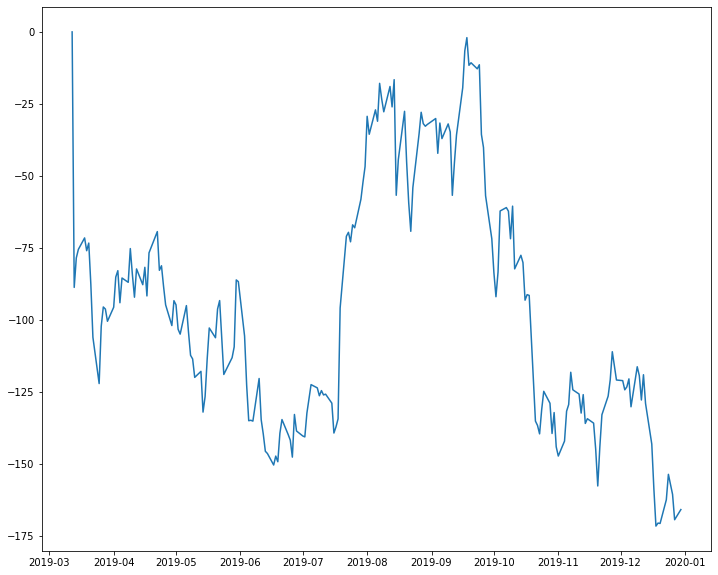

In [103]:
plt.figure(figsize = (12,10))
plt.plot(trade_df.index,trade_df.cum_Return)

### Plot the daily return with the signals

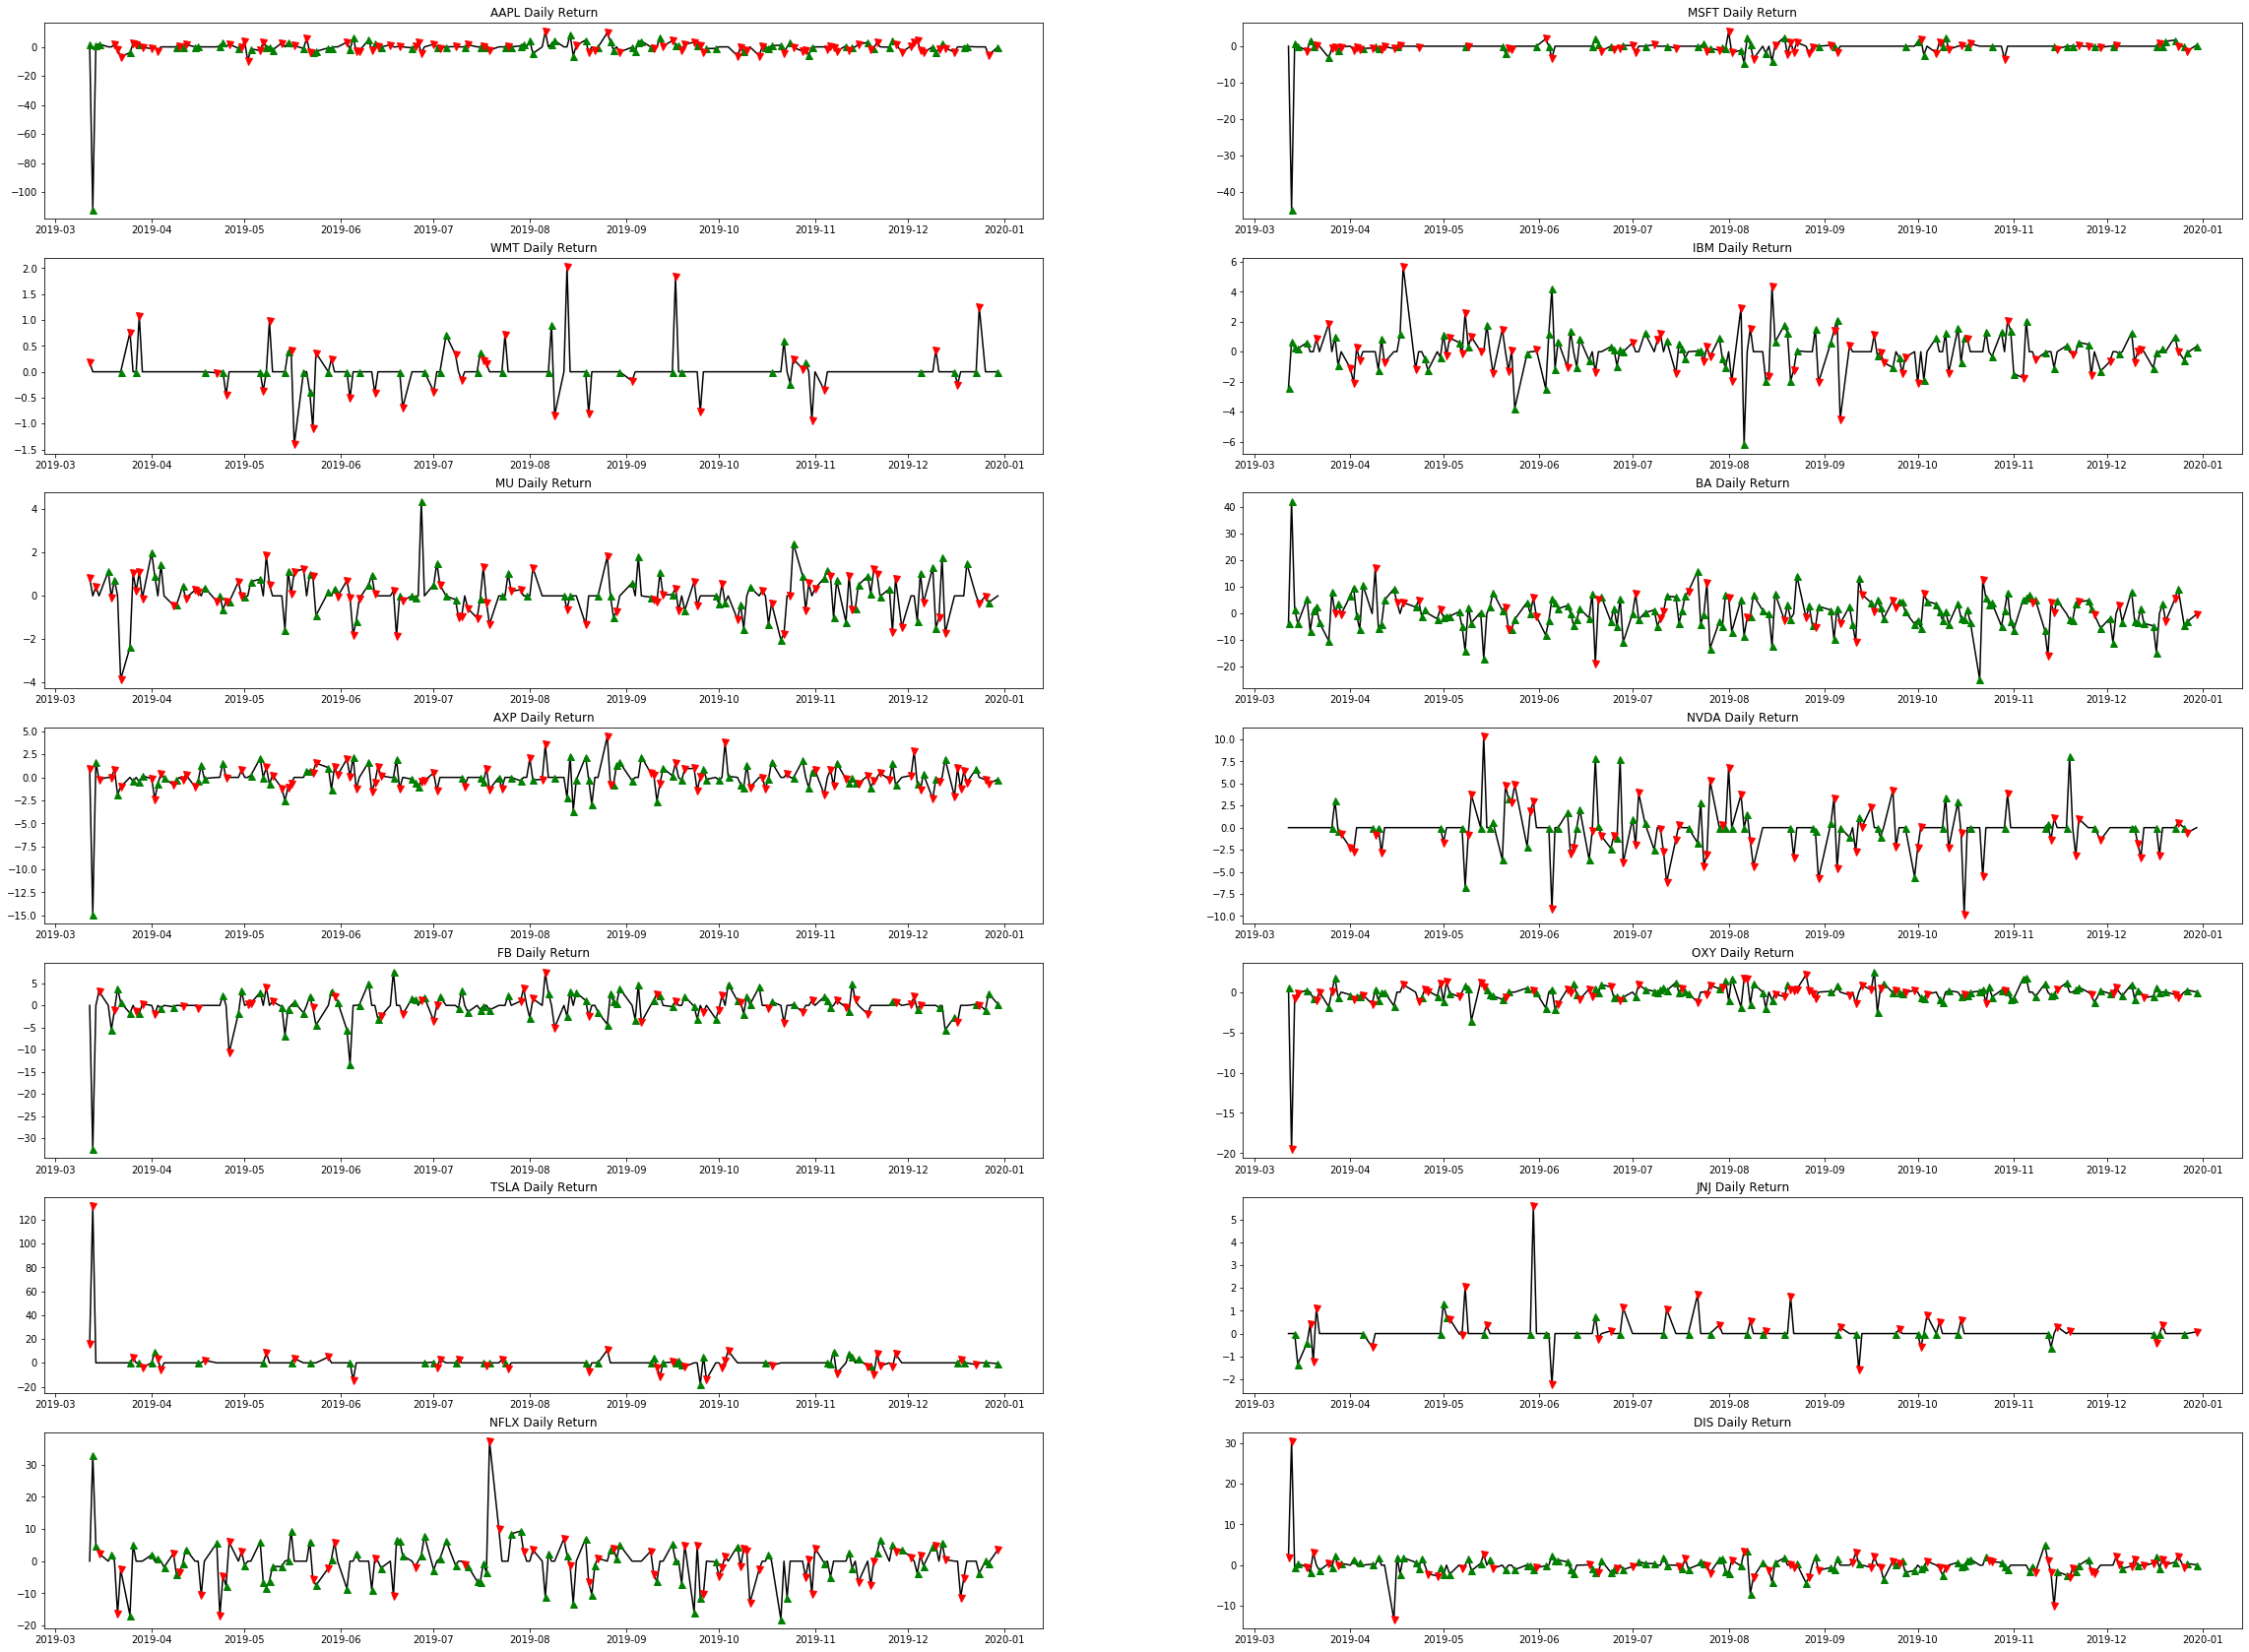

In [92]:
fig, ax = plt.subplots(nrows=len(tickers_list)//2, ncols= 2, figsize=(40, 30))
idx = 0
for row in ax:
    for col in row:
        
        ticker = tickers_list[idx]
        col.plot(trade_df.index, trade_df[f'{ticker}_Return'],  color = 'black',  label=f'{ticker} Daily Return')
        
        col.plot(trade_df.loc[trade_df[ticker + '_signal_tday'] == 1 ].index,
                    trade_df[f'{ticker}_Return'].loc[trade_df[ticker + '_signal_tday'] == 1 ], '^', color = 'green', markersize = 7)

        col.plot(trade_df.loc[(trade_df[ticker + '_signal_tday'] == -1) & (trade_df[ticker + '_Position_t-1'] >=1 ) ].index,
                    trade_df[f'{ticker}_Return'].loc[(trade_df[ticker + '_signal_tday'] == -1) & (trade_df[ticker + '_Position_t-1'] >= 1 ) ], 'v', color = 'red', markersize = 7)

        col.title.set_text(ticker + ' Daily Return')
        idx+=1

### Sharpe Ratio

In [94]:
def SR(df):
    return df.Daily_Return.mean()/df.Daily_Return.std()
    
sr = SR(trade_df)
print('The Sharpe Ratio for the testing period is :', sr)

The Sharpe Ratio for the testing period is : -0.06617349923747508


### Percentage of profitable trades

In [2]:
print('The percentage of the profitable trades is: ', round(trade_df.profit_pc[-1]*100, 3),'%')